## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np 
torch.manual_seed(0)
np.random.seed(0)
%matplotlib inline
import time
import pandas as pd
import os

In [142]:
if not os.path.exists("./TP2_results"):
    os.makedirs("TP2_results")

### [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* the size of each image is 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set

In [2]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

In [3]:
print("The shape of the dataset is :", dataset.data.size())

The shape of the dataset is : torch.Size([60000, 28, 28])


In [5]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Text(0.5, 1.0, 'image label: 0')

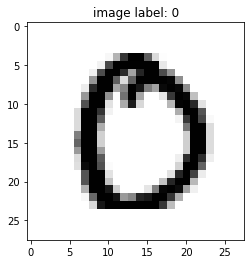

In [4]:
sample_index = 88

plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

### Training the neural network

In [8]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(28*28, 10)# Input size is 28*28, output size should be the same with the number of classes
        
    def forward(self, inputs):
        outputs = F.softmax(self.l1(inputs), dim=1)# Use softmax as the activation function for the last layer
        
        return outputs

In [104]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [154]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, model_type="linear", one_hot=True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            if model_type=="linear": y_pre = model(images.view(batch_size, -1)) 
            # reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            elif model_type=="conv": y_pre = model(images) #y_pre = model(images.unsqueeze_(1)) 
            else: raise NotImplemented
            # One-hot encoding or labels so as to calculate MSE error:
            if one_hot:
                labels_one_hot = torch.FloatTensor(batch_size, 10)
                labels_one_hot.zero_()
                labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
                labels = labels_one_hot
           
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [22]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0756
Epoch [2/10], Loss: 0.0484
Epoch [3/10], Loss: 0.0364
Epoch [4/10], Loss: 0.0305
Epoch [5/10], Loss: 0.0272
Epoch [6/10], Loss: 0.0251
Epoch [7/10], Loss: 0.0236
Epoch [8/10], Loss: 0.0225
Epoch [9/10], Loss: 0.0216
Epoch [10/10], Loss: 0.0209


Text(0.5, 1.0, 'Visualization of convergence')

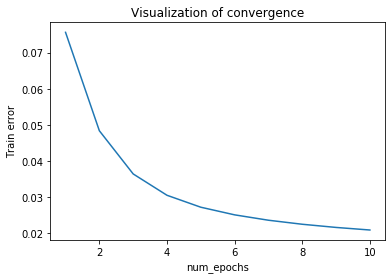

In [23]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [145]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model, model_type="linear"):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            if model_type=="linear": images = images.view(-1, 28*28)
            else:
                pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()
    acc = 100*correct.item()/ len(dataset)
    print('Accuracy of the model : {:.2f} %'.format(acc))
    return acc

In [25]:
accuracy(val_set, model)

Accuracy of the model : 88.29 %


Text(0.5, 1.0, 'Prediction label: 7')

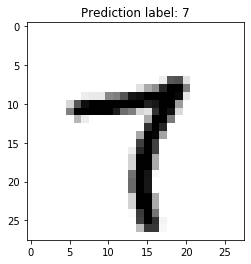

In [26]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 28*28))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [155]:
def conv_block(in_channels, out_channels, kernel_size, activation, *args, **kwargs):
    block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, *args, **kwargs), activation)
    return block

def linear_block(in_features, out_features, activation, *args, **kwargs):
    block = nn.Sequential(nn.Linear(in_features, out_features), activation)
    return block

class ConvModel(nn.Module):

    def __init__(self, activation:str, n_filters:list, n_neurons:list, in_channels=1, in_dim=28*28, out_dim=10, logits=False):
        super(ConvModel, self).__init__()

        activations = nn.ModuleDict([["relu", nn.ReLU()], ["lrelu", nn.LeakyReLU()], ["sigmoid", nn.Sigmoid()], ["tanh", nn.Tanh()]])

        self.conv_space_dim = [in_channels, *n_filters]
        self.conv_blocks = [conv_block(in_channels, out_channels, kernel_size=3, activation=activations[activation], padding=1)
        for in_channels, out_channels in zip(self.conv_space_dim, self.conv_space_dim[1:])]
        self.encoder = nn.Sequential(*self.conv_blocks)

        self.linear_space_dim = [self.conv_space_dim[-1]*in_dim, *n_neurons]
        self.linear_blocks = [linear_block(in_features, out_features, activations[activation]) for in_features, out_features in zip(self.linear_space_dim, self.linear_space_dim[1:])]
        self.fully_connected = nn.Sequential(*self.linear_blocks, nn.Linear(self.linear_space_dim[-1], out_dim))
        
    def forward(self, inputs):
        #outputs = F.softmax(self.encoder(inputs), dim=1)# Use softmax as the activation function for the last layer
        x = self.encoder(inputs)
        x = x.view(x.size(0), -1) # Flatten
        outputs = self.fully_connected(x)
        if not logits: outputs = F.softmax(x, dim=1)
    
        return outputs

### Grid evaluation

In [134]:
activations = ["relu", "lrelu", "sigmoid", "tanh"]
n_filters = [4, 8, 16, 32]
conv_layers = [0, 1, 2, 3]
fc_layers = [0, 1, 2]
n_neurons = [10, 15, 20]

In [139]:
results = {"filters": [], "neurons": [], "activation":[], "acc":[]}
start_time = time.time()
for filters in [[8, 8]]:
    for neurons in [[10]]:
        for activation in ["relu"]:
            print(f"------- Training model with filters : {filters}, activation : {activation}, and neurons: {neurons}")
            # Init model 
            model = ConvModel(activation=activation, n_filters=filters, n_neurons=neurons)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, model_type='conv')

            acc = accuracy(val_set, model, model_type="conv")

            curr_res = {"filters": n_filters, "activation":activation, "neurons":neurons, "acc":acc}
            [results[key].append(val) for key, val in curr_res.items()]

print(f"Grid evaluation took {time.time()-start_time} sec")         

------- Training model with filters : [8, 8], activation : relu, and neurons: [10]
Epoch [1/2], Loss: 0.0202
Epoch [2/2], Loss: 0.0083
Accuracy of the model : 95.22 %
Grid evaluation took 56.09870409965515 sec


In [143]:
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv(os.path.join("TP2_results", "ex1_grid_search.csv"))

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [148]:
filters, neurons, activation = [6, 6], [], "relu"

In [146]:
batch_size_list = [int(x) for x in np.linspace(10, 400, 5)]
lr_list = np.logspace(-3, 1, 5)
optimizer_dict = {"Adagrad": torch.optim.Adagrad, "Adam": torch.optim.Adam, "RMSprop": torch.optim.RMSprop, "SGD": torch.optim.SGD}

In [151]:
results = {"batch_size": [], "lr":[], "optimizer":[], "acc":[]}
start_time = time.time()
for batch_size in batch_size_list[:1]:
    for lr in lr_list[:1]: 
        for optim_name, optimizer in list(optimizer_dict.items())[:1]:     
            print(f"Training model with batch_size: {batch_size}, lr : {lr}, optimizer : {optim_name}")
            model = ConvModel(activation=activation, n_filters=filters, n_neurons=neurons)
            criterion = nn.MSELoss()
            optimizer = optimizer(model.parameters(), lr=lr)
            train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, model_type='conv')

            acc = accuracy(val_set, model, model_type="conv")

            curr_res = {"batch_size": batch_size, "lr":lr, "optimizer":optim_name, "acc":acc}
            [results[key].append(val) for key, val in curr_res.items()]
            
print(f"Grid evaluation took {time.time()-start_time} sec")         

Training model with batch_size: 10, lr : 0.001, optimizer : Adagrad
Epoch [1/2], Loss: 0.0239
Epoch [2/2], Loss: 0.0149
Accuracy of the model : 90.76 %
Grid evaluation took 51.23738217353821 sec


In [ ]:
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv(os.path.join("TP2_results", "ex2_grid_search.csv"))

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [152]:
activation, filters, neurons, optimizer, lr, batch_size = "relu", [6, 6], [], torch.optim.Adam, 1e-3, 10

In [153]:
criterion_dict = {"MSELoss": nn.MSELoss, "BCELoss": nn.BCELoss, "BCEWithLogitsLoss": nn.BCEWithLogitsLoss}
criterion_w_logits = ["BCEWithLogitsLoss"]

In [157]:
results = {"criterion": [], "acc":[], "num_epochs":[]}
start_time = time.time()
for criterion_name, criterion in criterion_dict.items():     
    print(f"Training model with criterion: {criterion_name}")
    logits = True if criterion_name in criterion_w_logits else False
    model = ConvModel(activation=activation, n_filters=filters, n_neurons=neurons, logits=logits)
    _criterion = criterion()
    _optimizer = optimizer(model.parameters(), lr=lr)
    
    one_hot = False if criterion_name in criterion_w_logits else True
    train_error =  train(num_epochs, batch_size, criterion, optimizer, model, train_set, model_type='conv', one_hot=one_hot)

    acc = accuracy(val_set, model, model_type="conv")
    
    curr_res = {"criterion": criterion_name, "acc":acc}
    [results[key].append(val) for key, val in curr_res.items()]

print(f"Grid evaluation took {time.time()-start_time} sec")         

Training model with criterion: MSELoss


RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv(os.path.join("TP2_results", "ex3_grid_search.csv"))

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.MNIST(root='data/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [ ]:
accuracy(test_set, model)